# **`DSML_WS_12` - Introduction to Unsupervised Learning**

This workshop deals with `unsupervised learning`. In unsupervised learning, we are not trying to predict a continuous value (regression) or a discrete value/class (classification) based on a set of features, but instead we are trying to find (hidden) structures in the data. Therefore, there is no exact measure to tell if your algorithm works well or does not (because we have no fixed reference (such as a label) to compare our results to). During this workshop, we will use clustering algorithms on datasets for which we __do__ have labels, just to give you a better intuition. In real world examples, however, assessing the quality of your clustering result is __more difficult__!

We will focus on hard clustering and review the following algorithms:
1. **Task: Using tree-based methods to predict electricity demand**
1. **Preparation for clustering**
1. **K-means clustering**
1. **Hierarchichal clustering**

---

## **1. Task: Using tree-based methods to predict electricity demand**

In last week's workshop, we talked about decision trees and ensemble methods and applied them to classify breast cancer cells. Let us see how this works in a regression setting, using our electricity demand dataset.

- Load data, define your X feature vector to include `Avg_temp` and `is_weekday` (which you first have to generate) and your Y vector to be `AVG`.
- Perform a train/test split.
- Train four different trees using `DecisionTreeRegressor`, with tree_depths ranging from 2 to 5.
- Train a gradient boosting model using `XGBRegressor` (you might have to read up on hyperparameters in the documentation).
- Train a random forest model using `RandomForestRegressor` (again, you might need to consult the documentation).
- Compare model performance using appropriate test metrics. Which model performs best?

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
# load data
df = pd.read_csv("Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")

# create binary variable
df["is_weekday"] = df["Date"].apply(lambda x: 1 if x.weekday() in [0,1,2,3,4] else 0)

# define matrices/vectors
X = df[["Avg_temp", "is_weekday"]].values
Y = df["AVG"].values

# perform train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# train decision trees
m1 = DecisionTreeRegressor(max_depth=2).fit(X_train, Y_train)
m2 = DecisionTreeRegressor(max_depth=3).fit(X_train, Y_train)
m3 = DecisionTreeRegressor(max_depth=4).fit(X_train, Y_train)
m4 = DecisionTreeRegressor(max_depth=5).fit(X_train, Y_train)

# train xgboost
m5 = XGBRegressor(booster="gbtree").fit(X_train, Y_train) # Only using  Default-Parameters here.

# train random forest
m6 = RandomForestRegressor(n_estimators=100,              # Only using  Default-Parameters here.
                           bootstrap=True,
                           random_state=42).fit(X_train, Y_train)

# evaluate performance
for i, model in enumerate([m1, m2, m3, m4, m5, m6]):
    mse = mean_squared_error(Y_test, model.predict(X_test))
    r2 = r2_score(Y_test, model.predict(X_test))
    print("Performance of model " + str(i+1) + ": MSE = " + str(mse) + ", R2 Score = " + str(r2))

# Print best model result.
print("Best model (m4): DecisionTreeRegressor with tree depth of 5.")
# Note: Ensemble Methods like Random Forests and XGBoost are particularly good in high-dimensional context.

Performance of model 1: MSE = 0.02123078402191302, R2 Score = 0.6020374380854251
Performance of model 2: MSE = 0.01593141544189695, R2 Score = 0.7013719843017154
Performance of model 3: MSE = 0.011507567635784925, R2 Score = 0.784295243500406
Performance of model 4: MSE = 0.009698306925098996, R2 Score = 0.8182091124773031
Performance of model 5: MSE = 0.010512554323886002, R2 Score = 0.8029463703892529
Performance of model 6: MSE = 0.012191399667806286, R2 Score = 0.7714770853437602
Best model (m4): DecisionTreeRegressor with tree depth of 5.


---

## **2. Preparation for clustering**

### **Dataset used throughout the workshop: Iris flowers**

For a first intuition, we will be working on the iris dataset again, which you all are familiar with by now. As you remember, in reality there are __three__ different species of irises in the dataset. So, let's see whether we are able to confirm this number of __clusters__ in our dataset using unsupervised learning.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [34]:
iris = pd.read_csv('iris.csv', index_col="number").dropna(axis=0)
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
number,,,,,
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


To make this an unsupervised learning task we need to drop the label (i.e. `Species`). For later checks we save the response as variable `y`.

In [35]:
X = iris.drop("Species", axis=1)
y = iris["Species"]
X.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2
4,4.6,3.1,1.5,0.2
5,5.0,3.6,1.4,0.2


### **Data Preparation and Scaling**

First, let's start out by scaling the data. The K-Means algorithm (and any other clustering algorithm for that matter) minimizes some intra-cluster distance (while maximizing inter-cluster distances). For the case of k-means this is typically defined as the **euclidean distance** from the midpoint of each cluster to all points in this cluster. Other distance metrics are also sometimes used (e.g., **Manhattan distance**)

If one feature has a bigger spread than others it will be more important than other factors for the outcome of the clustering. We will revisit this later! For now, let's standardize!

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()         # standardisation is crucial
scaler.fit(X)                     # X includes all variables for clustering
X_scaled = scaler.transform(X)

# create a df out of the array
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,-0.893244,1.002051,-1.333018,-1.300856
2,-1.137464,-0.139130,-1.333018,-1.300856
3,-1.381684,0.317342,-1.390008,-1.300856
4,-1.503795,0.089106,-1.276029,-1.300856
5,-1.015354,1.230287,-1.333018,-1.300856


In [37]:
iris_scaled = X_scaled_df
iris_scaled["Species"] = iris["Species"]

The typical patterns remain in the scaled data, just at a different scale.

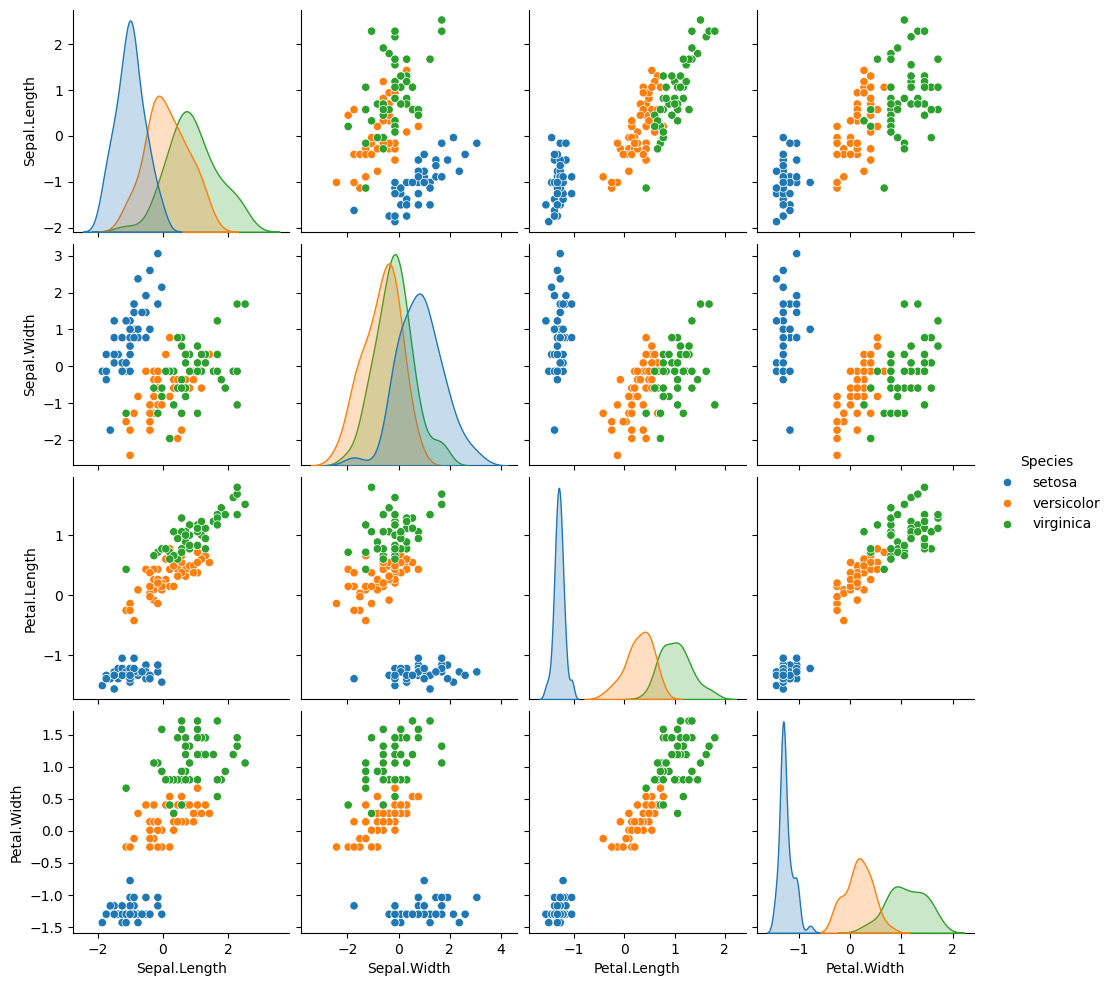

In [38]:
sns.pairplot(data=iris_scaled, hue="Species")
plt.show()

### **Supervised learning case (classification)**

Before we start with the actual clustering, let's revisit the classification methods we talked about during past workshops and see how well they are doing in terms of classification error. For that, we are importing a `kNN classifier` from the sklearn library and have a look at the confusion matrix and the classification report.

kNN has some intuitive parallels to k-means clustering (see lecture material).

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [40]:
# Note that we are not doing a train-test-split or other advanced methods here; this is not a valid approach for a real supervised learning project!
model_neigh = KNeighborsClassifier(n_neighbors=5)
model_neigh.fit(X_scaled,y)

KNeighborsClassifier()

In [41]:
y_pred = model_neigh.predict(X_scaled)     # Recall: Predictions are made by distance to neighbouring values.

To review the performance of our classifier we check relevant test metrics, which you are familiar with by now. We use the `classification_report` class to return a neat summary of the most important classification metrics. We also review the previously discussed `confusion_matrix`.

In [42]:
iris["SpeciesPred"] = y_pred
print(classification_report(y,y_pred))            # We perfectly predict the setosa-class!

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        49
  versicolor       0.92      0.96      0.94        49
   virginica       0.96      0.92      0.94        48

    accuracy                           0.96       146
   macro avg       0.96      0.96      0.96       146
weighted avg       0.96      0.96      0.96       146



In [43]:
classification_conf_matrix = confusion_matrix(y,y_pred)
classification_conf_matrix

array([[49,  0,  0],
       [ 0, 47,  2],
       [ 0,  4, 44]])

## 3. **K-means clustering**

Now, let's drop the labels and just have a look at the given features. How would we group the datapoints for the different observed flowers?
In a typical unsupervised learning case we normally just have a rough idea of how many clusters to expect.

Three approaches are commonly applied:
1. Use **expert knowledge**
1. Plot **residual loss** for different numbers of clusters, find **'elbow'** and select corresponding number of clusters
1. Use **hierarchical clustering** to detect suitable branching and corresponding number of clusters

We will focus on the residual loss (**elbow method**) as a selection criterion for now. In practice, a combination of all three methods is often used.

### **Elbow Method**

In [44]:
from sklearn.cluster import KMeans

In [45]:
k_max = 20  # we have 147 datapoints, more than 20 clusters are definitely not reasonable!

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)      # initialize  / k+1 due to 0-indexing in python.
    model.fit(X_scaled)                 # fit

    # store number of clusters
    clusters.append(k+1)

    # store according losses (Inertia: Sum of squared distances of samples to their closest cluster center)
    losses.append(model.inertia_)   # Recall definition from lecture slides (Lecture 12, Slide 30)

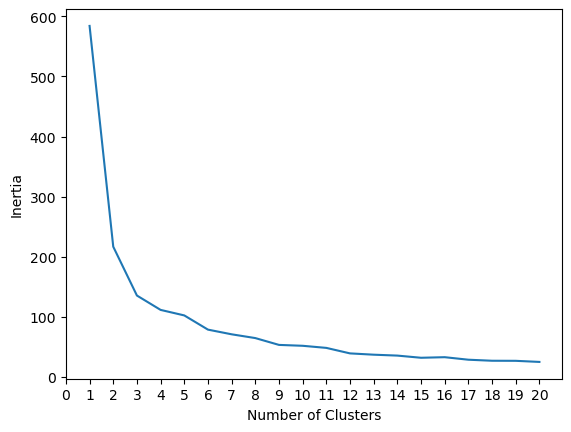

In [46]:
plt.plot(clusters, losses)
plt.ylabel("Inertia")
plt.xlabel("Number of Clusters")
plt.xticks(range(k_max+1))
plt.show()

Let's zoom in in the good region by limiting the x-axis

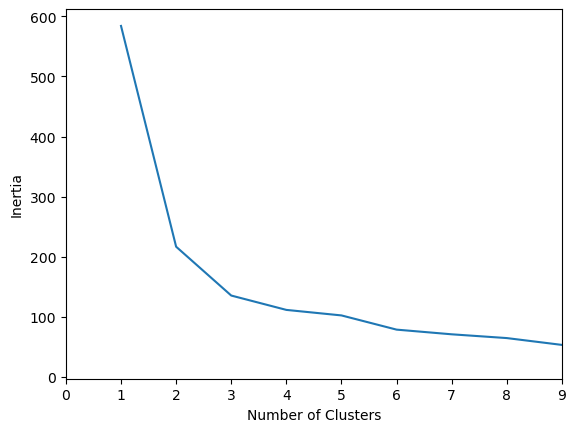

In [47]:
plt.plot(clusters, losses)
plt.ylabel("Inertia")
plt.xlabel("Number of Clusters")
plt.xlim([0,9])
plt.show()

From this plot we would expect a good amount of clusters to lie in the region of two to five. Of course, we know that the correct answer is 3 (i.e., one per each species). However, in a true unsupervised learning setting there is no frame of reference and we'd need to draw on several indicators (quantitative and qualitative) to settle on a final number of clusters. For illustrative purposes let's select k=2, the minimum sensible choice.

In [48]:
# re-fit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)                   # Cluster decisions are made by distance to centroid of cluster!

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's plot the results.

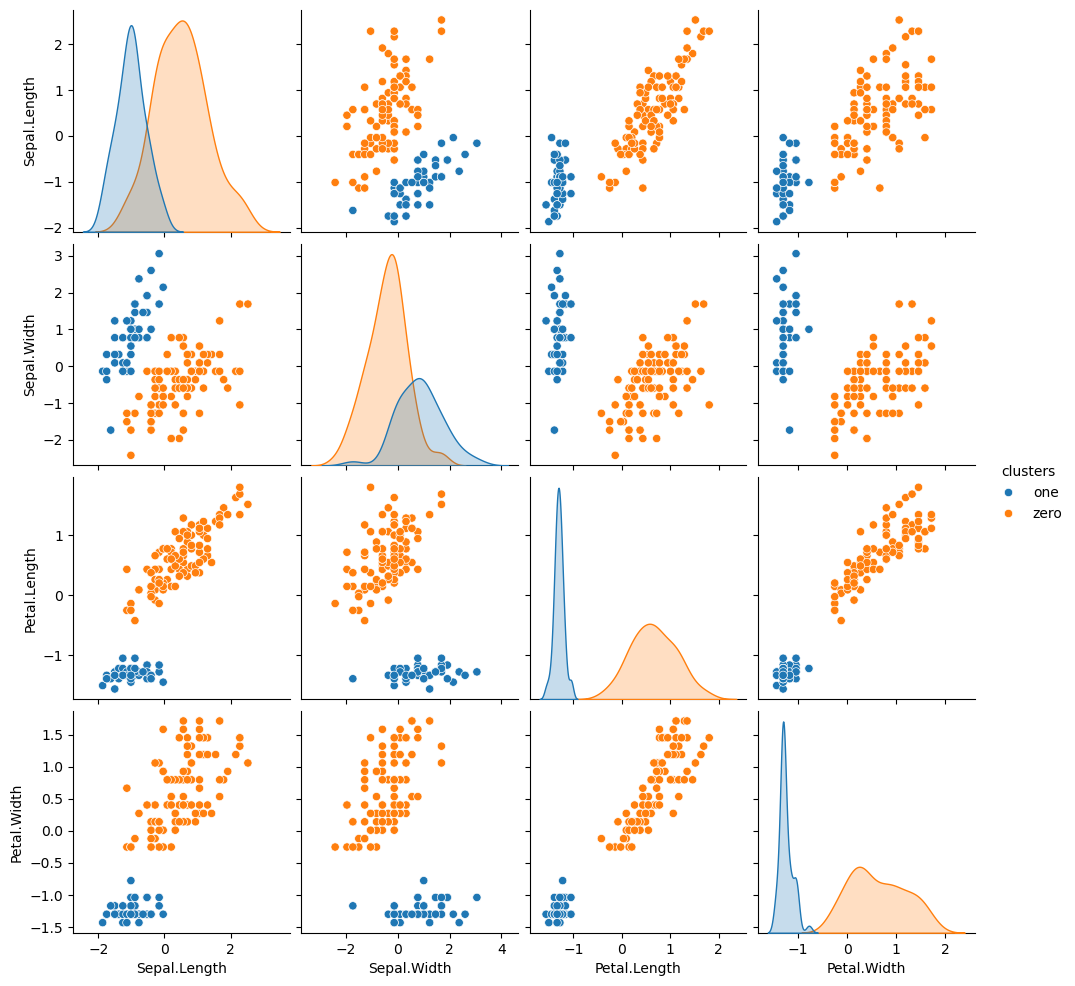

In [49]:
numbers = ["zero", "one", "two", "three","four","five"]
iris_scaled["clusters"] = two_means.predict(X_scaled)
iris_scaled["clusters"] = iris_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="clusters")
plt.show()                                       # Comparison with actual classification?

Now let's do this for the "correct" number of cluster, i.e., three.

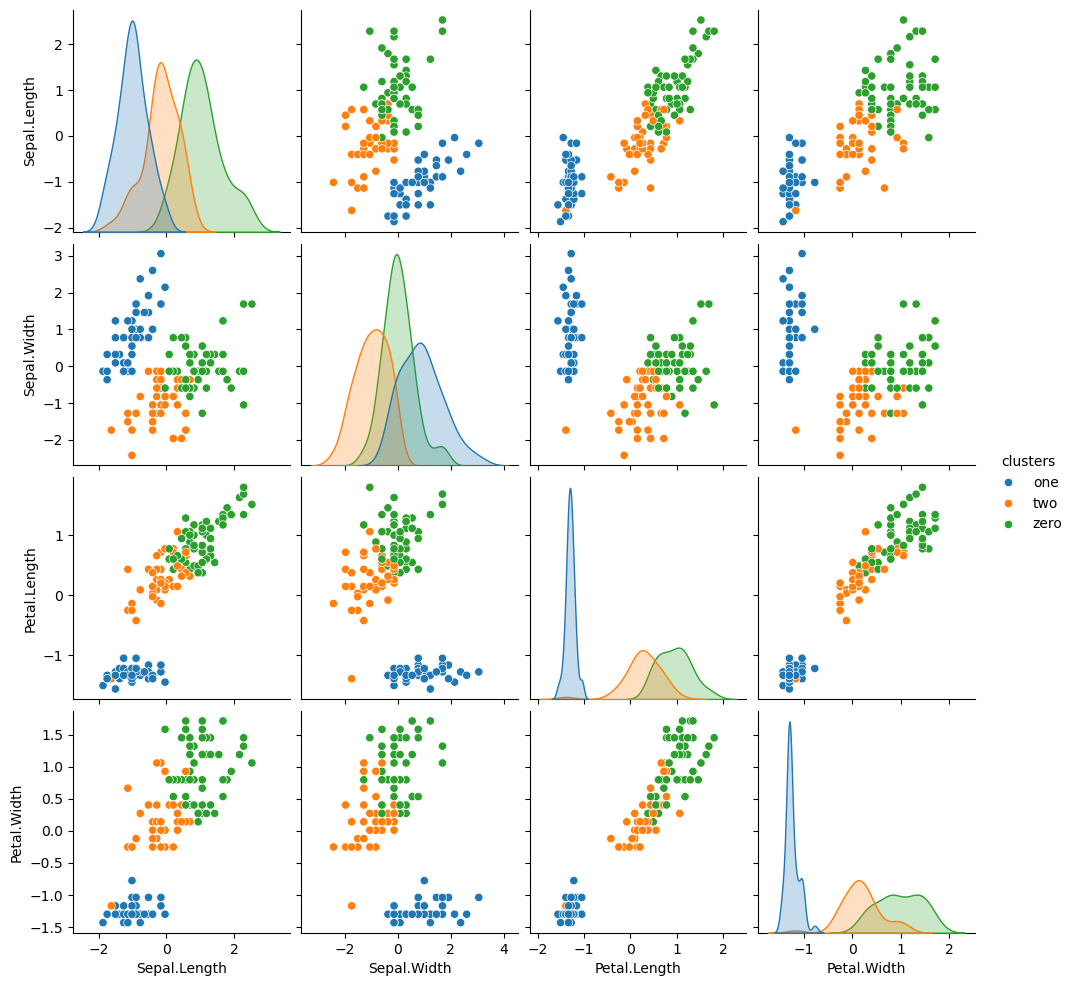

In [50]:
three_means = KMeans(n_clusters=3)
three_means.fit(X_scaled)
iris_scaled["clusters"] = three_means.predict(X_scaled)
iris_scaled["clusters"] = iris_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="clusters")
plt.show()                                        # Comparison with actual classification?

How would k=5 fare?

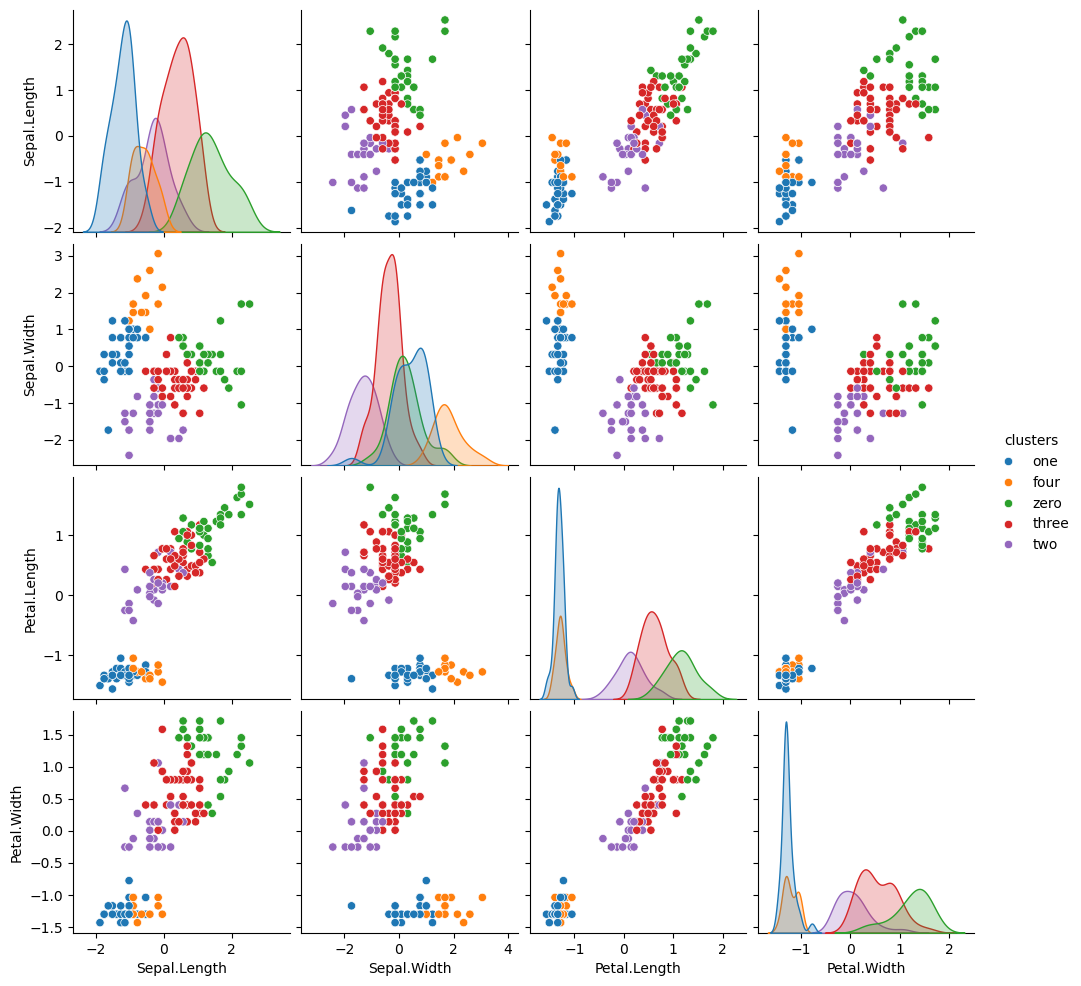

In [51]:
five_means = KMeans(n_clusters=5)
five_means.fit(X_scaled)
iris_scaled["clusters"] = five_means.predict(X_scaled)
iris_scaled["clusters"] = iris_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="clusters")
plt.show()                                                # We fit too many clusters here!

From inspection, we can tell that k=5 achieves relatively poorer inter-cluster separation (e.g., 1 and 3 are very similar). From these analyses, a data scientist would most likely select 3 clusters.

### **Silhouette-Score**

Let us implement a second very neat way of evaluating clusters - a silhouette score analysis. The silhouette score is a measure of inter- and intra-cluster distance that is defined in the range of -1 to 1, where

- **1** indicates **perfect** cluster assignment and
- **-1** indicates **incorrect** cluster assignment.

**Recall from the lecture:**

The silhouette score can be calculated *for every single sample*:

\begin{equation*}
s = \frac{b - a}{\max(a, b)}
\end{equation*}

where  
- **a** = mean distance between the sample and all other points in the same cluster  
- **b** = mean distance between the sample and all other points in the next nearest cluster  

For n_clusters = 2 The average silhouette_score is : 0.5807839134033137
For n_clusters = 3 The average silhouette_score is : 0.46272783910396975
For n_clusters = 4 The average silhouette_score is : 0.3890046064330274
For n_clusters = 5 The average silhouette_score is : 0.3427818070612544


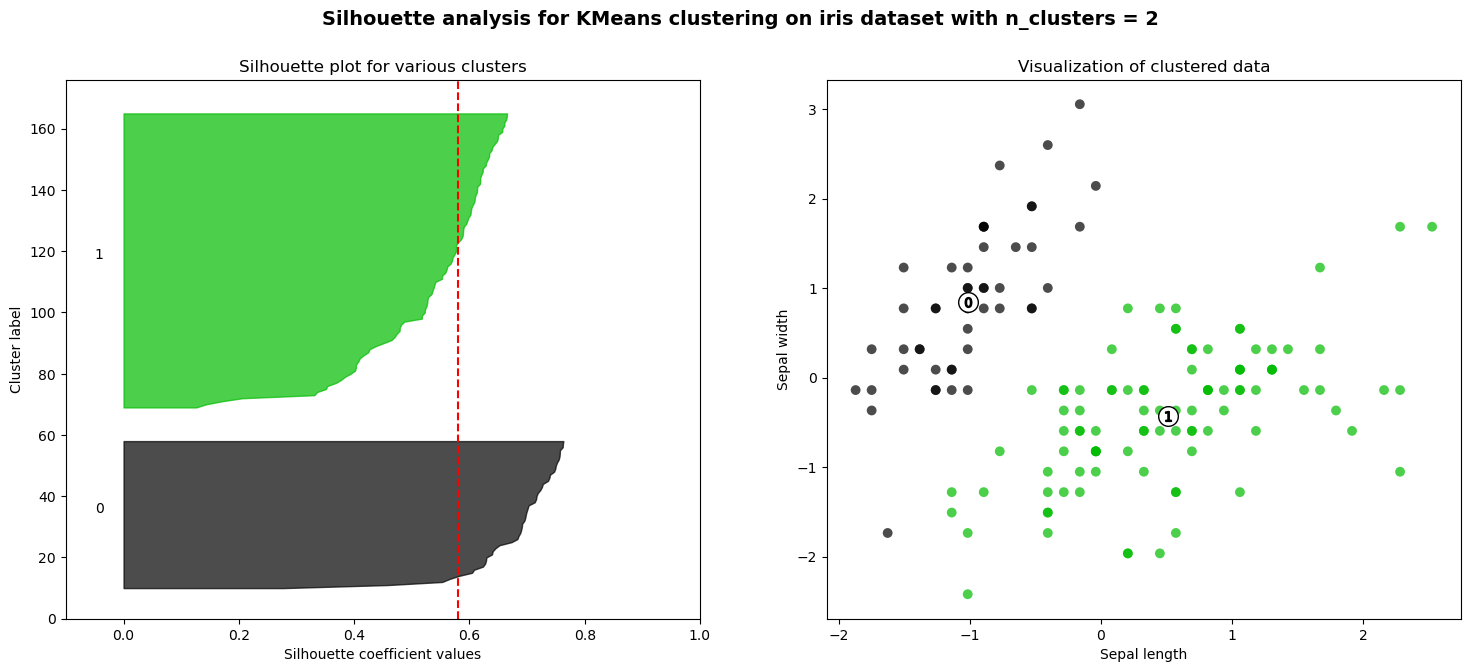

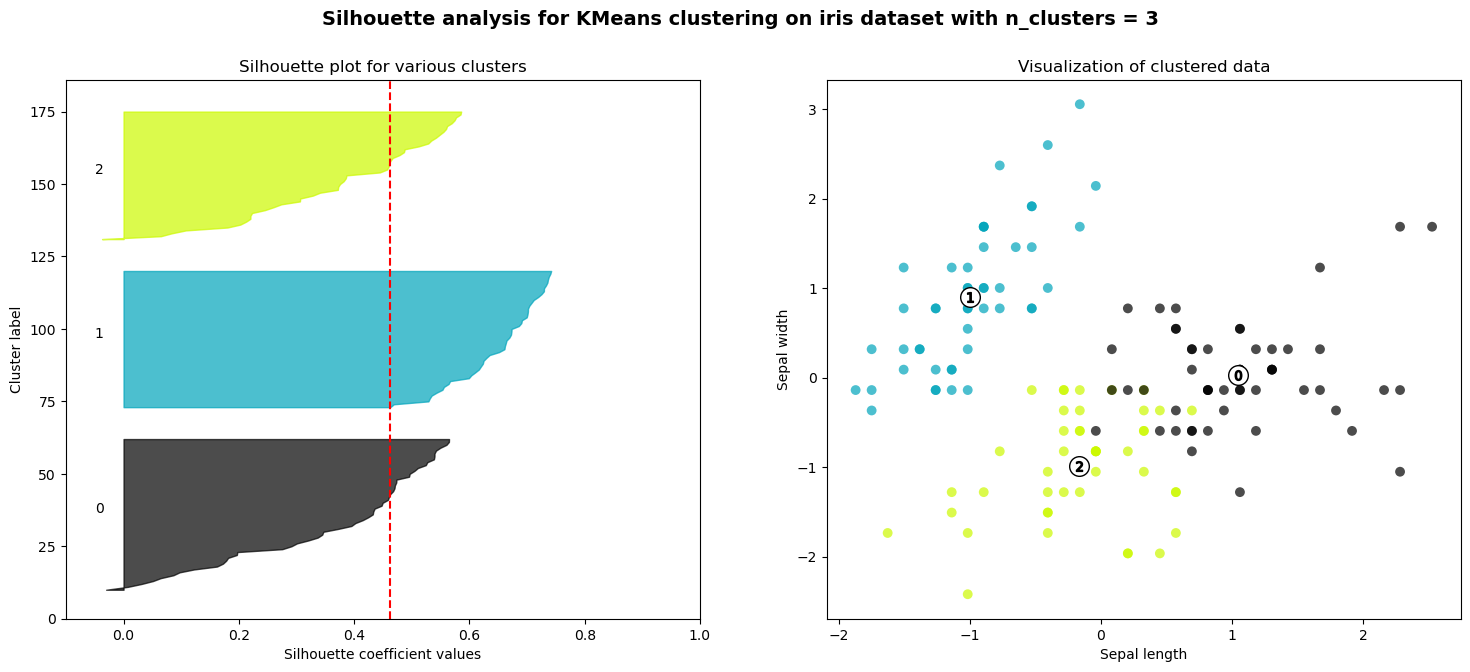

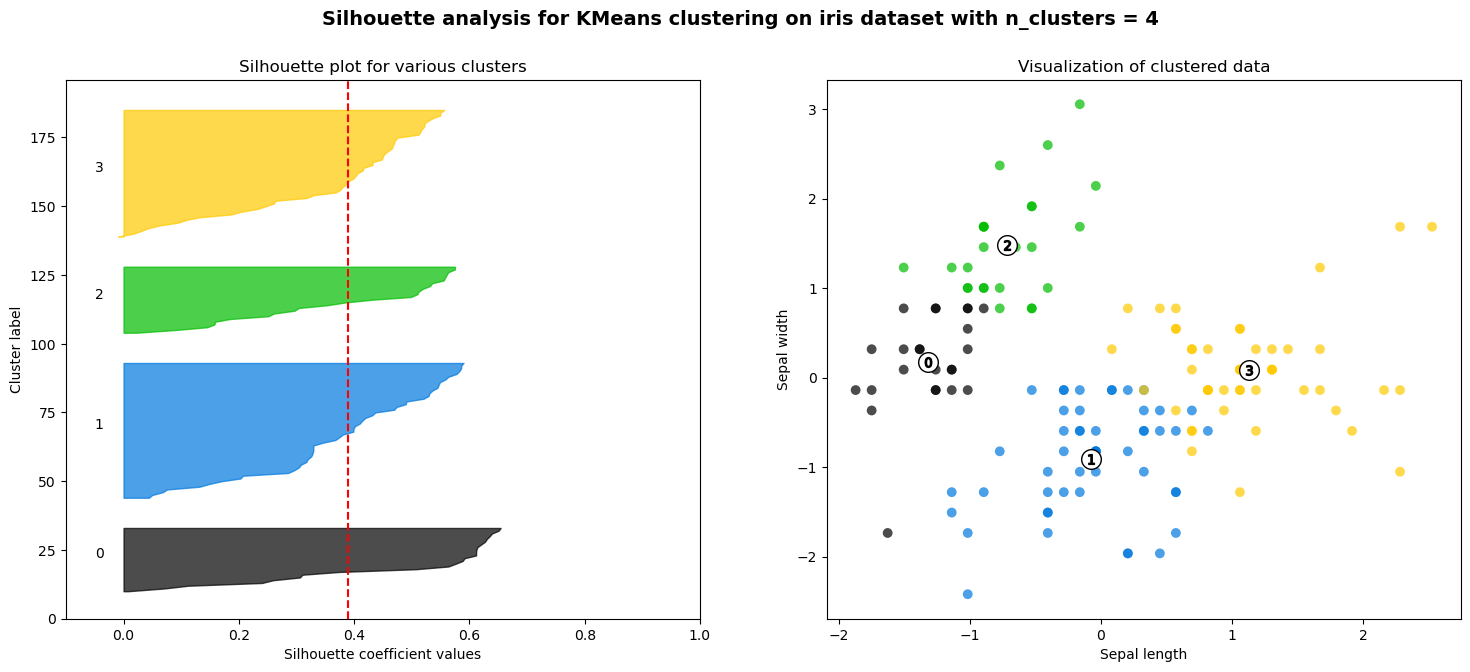

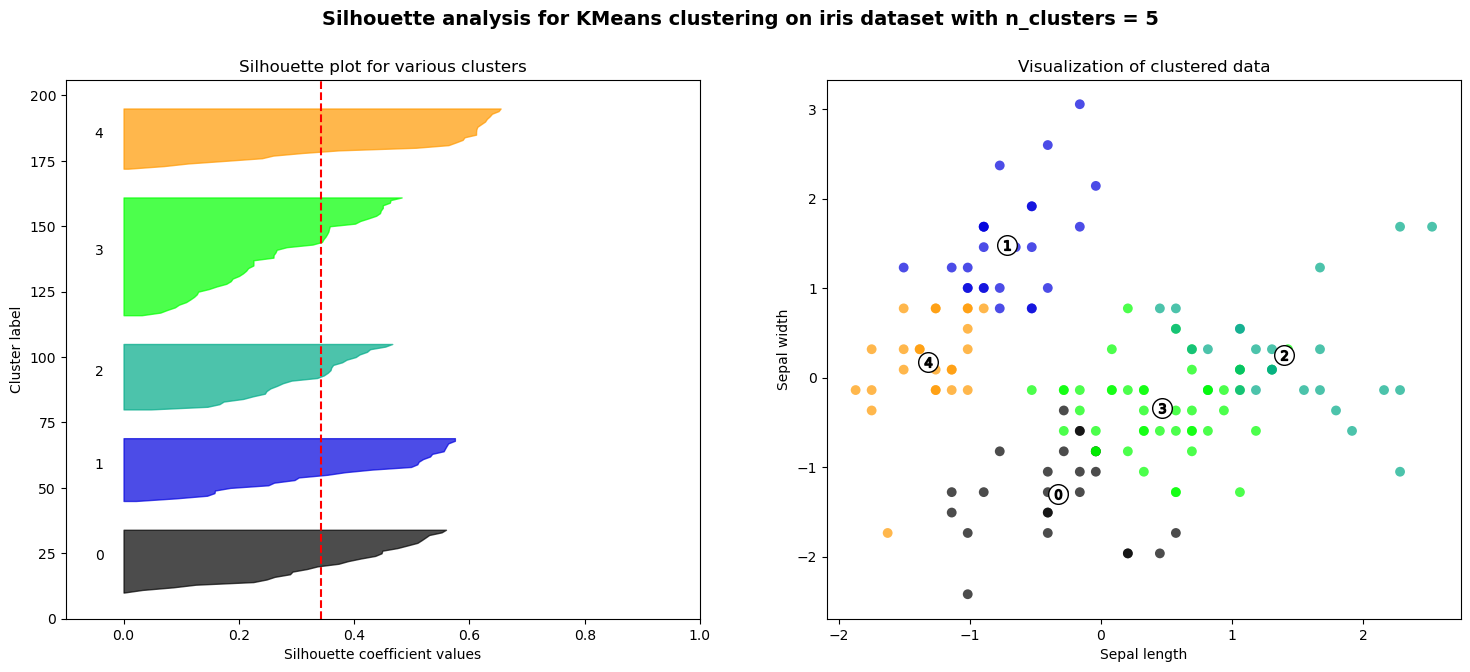

In [52]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5]                     # Specify the number of clusters that we want to evaluate

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # initialize k-means with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)              # AVERAGE SCORE
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)   # SCORE FOR EACH SAMPLE

    y_lower = 10
    for i in range(n_clusters):
        # aggregate silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]    #Filter silhouette scores for cluster i

        ith_cluster_silhouette_values.sort()                   # Sort individual scores

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")          # RED LINE: AVERAGE SCORE

    # 2nd plot showing actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_scaled[:, 0], X_scaled[:, 1], marker=".", s=200, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # labeling clusters
    centers = clusterer.cluster_centers_          # Finds the center of each cluster
    # draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of clustered data")
    ax2.set_xlabel("Sepal length")
    ax2.set_ylabel("Sepal width")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on iris dataset with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

## 4. **Hierarchical Clustering**

Unlike K-Means, hierarchical clustering defines step-wise decision rules for how to seperate the data into clusters. This has the advantage that it is more resembling the human decision making process and is, therefore, very intuitive for stakeholders to understand. 


Let's have a look at how a supervised decision tree would look like for our iris dataset and then back this up with an unsupervised hierarchical clustering.

### **Supervised Learning Case - Decision Trees for Classification**

The supervised equivalent of hierarchichal clustering is decision tree classification, which we will briefly re-visit in this section.

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model_tree = DecisionTreeClassifier(max_depth=2)

# we engineer a new feature here to enhance performance
X["Petal.Area"] = X["Petal.Length"]*X["Petal.Width"]
model_tree.fit(X, y)
y_pred_tree = model_tree.predict(X)                             # Recall: Predictions result from recursive partitioning (Splitting the data)

In [54]:
print(classification_report(y_true=y, y_pred=y_pred_tree))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        49
  versicolor       1.00      0.92      0.96        49
   virginica       0.92      1.00      0.96        48

    accuracy                           0.97       146
   macro avg       0.97      0.97      0.97       146
weighted avg       0.97      0.97      0.97       146



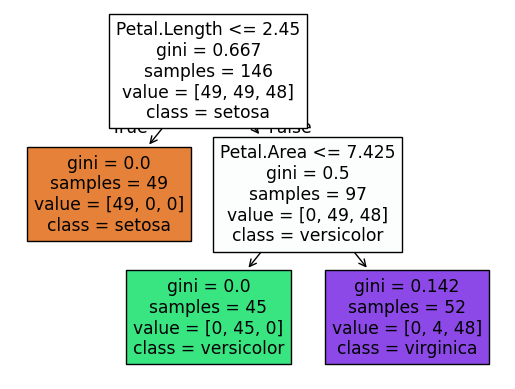

In [55]:
tree.plot_tree(model_tree, class_names=y.unique().tolist(), feature_names=X.columns.tolist(), filled=True)
plt.show()

### **Unsupervised Learning Case - Agglomerative/Hierarchichal Clustering**

In agglomerative hierarchical clustering, we begin with every observation in an own cluster and keep joining records into clusters until only one single cluster is left. Obviously, neither extreme is useful, so we need to find the sweet spot in between. Compared to k-means, we do not need to specify the number of clusters in advance. Alternatively, we generate a plot called dendrogram to help us decide on an appropriate number of clusters. Let's see how this works in practice.

In [56]:
X_scaled = StandardScaler().fit_transform(X)

In [57]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.show()

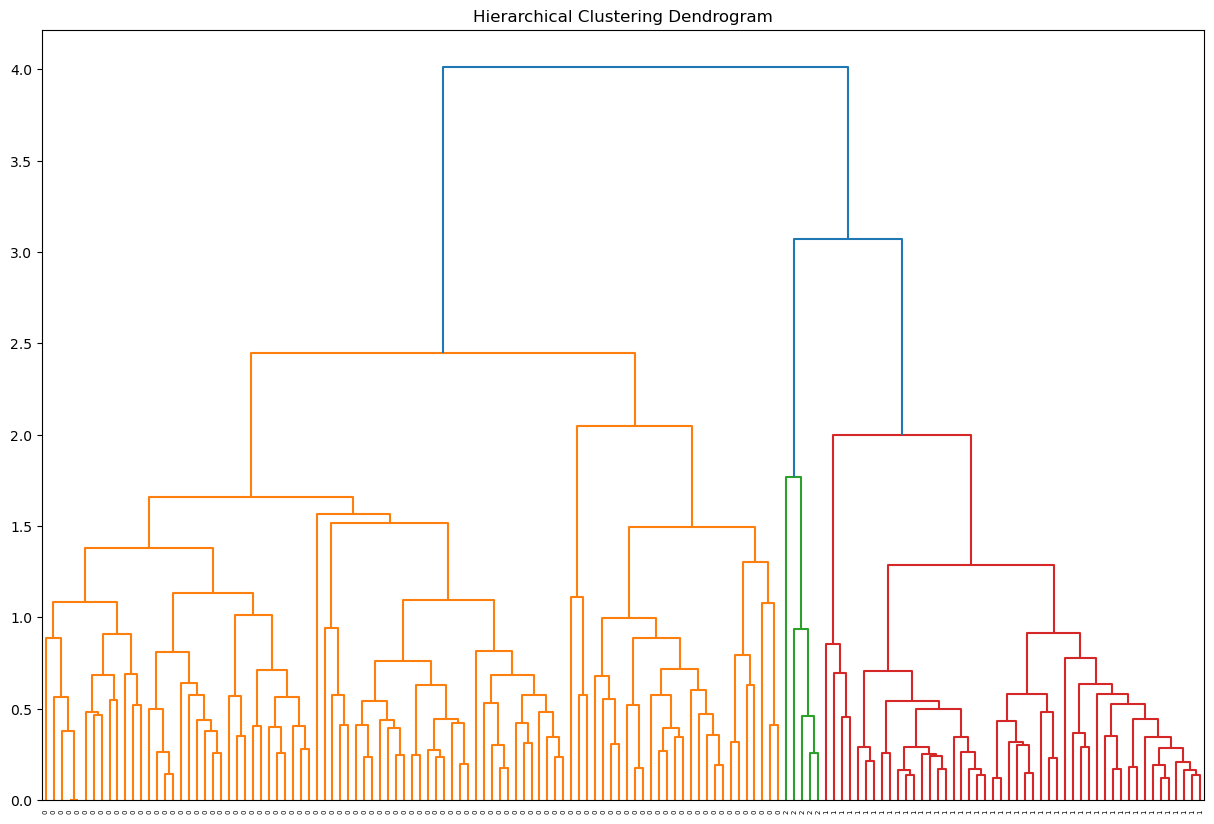

In [58]:
# plot
agglo = AgglomerativeClustering(compute_distances=True,   # Needed for Dendogram-Plots
                                linkage='average',        # Choose a linkage algorithm: Lecture mentions average linkage.
                                n_clusters=3)             # Uses Euclidian Distance as default. 
y_pred_agglo = agglo.fit_predict(X_scaled)                # Groups of cluster result from recursive merging of closest clusters

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)

In [59]:
iris_hierarchical = pd.DataFrame(X_scaled, columns=X.columns)
iris_hierarchical["Agglo_clusters"] = y_pred_agglo
iris_hierarchical["Species"] = iris["Species"].values

iris_hierarchical.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Petal.Area,Agglo_clusters,Species
0,-0.893244,1.002051,-1.333018,-1.300856,-1.165154,1,setosa
1,-1.137464,-0.139130,-1.333018,-1.300856,-1.165154,1,setosa
2,-1.381684,0.317342,-1.390008,-1.300856,-1.169416,1,setosa
3,-1.503795,0.089106,-1.276029,-1.300856,-1.160893,1,setosa
4,-1.015354,1.230287,-1.333018,-1.300856,-1.165154,1,setosa


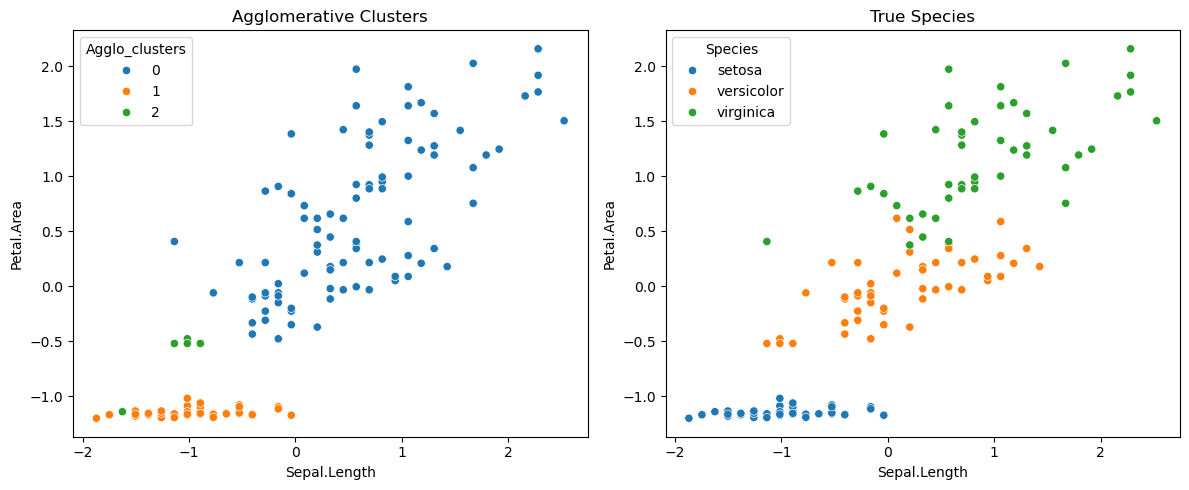

In [60]:
# Define similar color palette for both plots
color_mapping = {
    "setosa": "#1f77b4",         # blue
    "versicolor": "#ff7f0e",     # orange
    "virginica": "#2ca02c",      # green
    0: "#1f77b4",                # cluster "setosa" 
    1: "#ff7f0e",                # cluster "versicolor"
    2: "#2ca02c",                # cluster "virginica"
}

# Both plots, horizontally aligned.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x="Sepal.Length", y="Petal.Area", data=iris_hierarchical, palette=color_mapping, hue="Agglo_clusters", ax=axes[0])
axes[0].set_title("Agglomerative Clusters")   # Predictions

sns.scatterplot(x="Sepal.Length", y="Petal.Area", data=iris_hierarchical, palette=color_mapping, hue="Species", ax=axes[1])
axes[1].set_title("True Species") # Actual classes

plt.tight_layout()
plt.show()

---